# DeepLearning nagyHF II. milestone
## Team - balit_learning : Gurubi Barnabás - DXEXVR, Mátyás Gergely - IL21NI, Horváth Ákos - DKILK6

## Problem: Colorizing black and white pictures (with user interactions)

As we mentioned in our previous milestone we would like to create a neural network which can colorize black and white pictures. In adition to this we would like to provide a possibility for the user to change the result (colorized) image by giving the color of certain points in the original (black and white) image.

At the moment we have a dataset of ~70k images. (we wrote a script in the previous milestone, this time we will only upload the pictures in a .zip).
## TODO - ha nem változik a képméret ezt törölni kell, vagy ha nem akarjuk kiemelni
We changed the size of the pictures because we found a relatively good network in an article that uses 256x256 sized pictures for colorization.
Note: Also we changed the names of the pictures to numbers like 1,2,3,4... to make it easier to load and use them.

## Required imports for this project

In [ ]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

### Running out of memory while loading the pictures

So we realized that we could not load in all the 70k pictures at the same time because they would consume too much memory. However the pictures use only 750 MB space, if we load them into 256x256x3 sized tensors (for the 256x256 pixels and the 3 color channels) they need 256 * 256 * 3 * 4 bytes = 786 432 bytes = ~0.8 MB. (since we use float numbers). SO if we would like to load in 70k pictures and each one of them uses 0.8 MB space we would need ~56 000 MB = 56 GB memory. It is almost impossible to have that much memory (especially if we use GPU for training), so we load in only batch-size pictures at a single time. We wrote a new class to handle the picture loading: __DataGenerator__

### The DataGenerator class:

# TODO általános leírás - angol kommentezés, leírás

We found out that there is a way in keras to train the network with batches of data. The _Sequential.fit_generator()_ method trains the network with data which is generated __batch-by-batch__ by a Python generator. We implemented a Python generator, the class called __DataGenerator__.

Before we can explain the class, we shall discuss another part of the code, which we created for the same manner as the generator class. 

### Using indexes to access the data
The main problem is the earlier mentioned size of the dataset. If we want to load the data for splitting it into train, validation and test sets, we immediately bump into the not enough memory problem. Instead of this, we should assing __indexes__ to the data. Then if we split the indexes, the separation of the data is solved. We can make partitions from the indexes (_train, validation, test_).

The least complicated way to assign ids to the files, is giving names to the files same as the ids. Accordingly we did this in advance. We can easily do this with shell scripts, e.g. on windows you can use the following PowerShell script:
    _Dir | %{Rename-Item $_ -NewName ("nyc_trip_{0}.jpg" -f $nr++)}_

In [4]:
#The range of existing file names (therefore ids)
all_id = list(range(1000, 10293))

#The split proportions
valid_split = 0.1
test_split = 0.1

#The split indexes
v_index = int(len(all_id)*(1-valid_split-test_split))
t_index = int(len(all_id)*(1-test_split))

#Splitting the id sets
train_ids = all_id[:v_index]
valid_ids = all_id[v_index:t_index]
test_ids = all_id[t_index:]

#Printing the length of the id sets
print("Length of train set: " + str(len(train_ids)))
print("Length of validation set: " + str(len(valid_ids)))
print("Length of test set: " + str(len(test_ids)))

#Storing them for later usage
partition = {'train': train_ids, 'validation': valid_ids, 'test': test_ids}

Length of train set: 7434
Length of validation set: 929
Length of test set: 930


In [1]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(256,256,1), shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *(256,256,1)), dtype=float)
        Y = np.empty((self.batch_size, *(256,256,2)), dtype=float)
        I = np.empty((self.batch_size, 1000))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = img_to_array(load_img('Train/' + str(ID) + '.jpg'))
            grayscaled_rgb = gray2rgb(rgb2gray(img))
            grayscaled_rgb = grayscaled_rgb.reshape((1,*(grayscaled_rgb.shape)))
            img = 1.0/255*img
            img = rgb2lab(img)
            gray = img[:,:,0]
            ab = img[:,:,1:] / 128
            
            # Inception
            I[i,] = create_inception_embedding(grayscaled_rgb)
            
            # Store sample
            X[i,] = gray.reshape((256,256,1))

            # Store class
            Y[i,] = ab

        return {'encoder_input': X, 'embed_input': I}, Y


c:\users\ákos\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## The network

We found the basic network in an article. We decided to start from this as they got a relatively nice result with it.
It uses for the encoder:
# TODO aki érti rendesen hogy milyen layerek vannak
Then for the decoder:
# TODO szintén..

In addition to these layers there is another trick that improves the result:
The input pictures also run through the the inception resnet v2 network which is one of the most powerful classifiers nowadays. (it can classify the pictures into 1000 classes)
# TODO Ha akarunk a resnetről részletesebben írni
# TODO Ha átakarjuk írni .Add() okkal a modellt
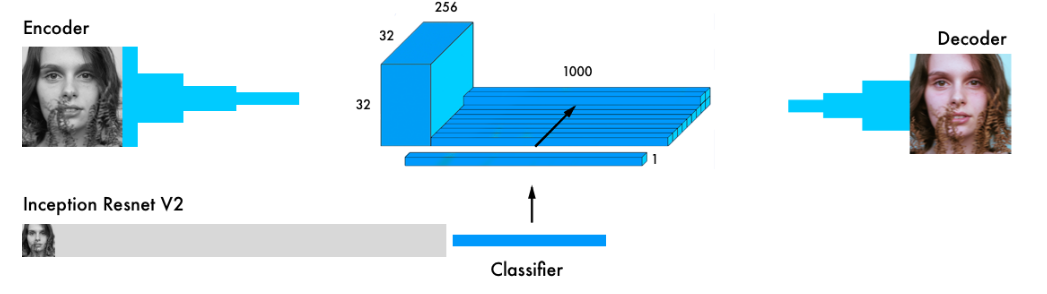
# TODO ez a kép benne maradjon e attól hogy nem mi csináltuk?

In [2]:
embed_input = Input(shape=(1000,), name='embed_input')

#Encoder
encoder_input = Input(shape=(256, 256, 1,), name='encoder_input')
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

## Running the images through _inception resnet v2_

This is the function that resizes the given image to 299x299 since the inception resnet v2 uses this size.
As a result the function returns prediction.

In [3]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        #print(i.shape)
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

### Loading in the InceptionResNetV2

In [4]:
#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

### Setting up the variables for the input

We use a train/valid/test split of 0.8/0.1/0.1

In [5]:
##Ossz hany kepbol tanuljon
all_id = list(range(0, 10))

valid_split = 0.1
test_split = 0.1

v_index = int(len(all_id)*(1-valid_split-test_split))
t_index = int(len(all_id)*(1-test_split))

train_ids = all_id[:v_index]
valid_ids = all_id[v_index:t_index]
test_ids = all_id[t_index:]

partition = {'train': train_ids, 'validation': valid_ids, 'test': test_ids}

### Loading the inputs using the _DataGenerator_ class and starting the training

In [7]:

##A kepeket 10-esevel betoltogeto cucc (bazch_size, hogy hanyasaval toltse be)
training_generator = DataGenerator(partition['train'], batch_size=1)

#Train model      
model.compile(optimizer='rmsprop', loss='mse')
model.fit_generator(training_generator, epochs=10, steps_per_epoch=8) #a steps_per_epoch=ossz_kep/batch_size 100/10

Epoch 1/10


StopIteration: [Errno 2] No such file or directory: 'Train/7.jpg'

## Testing the network and evaluating the results

For the test we load in some random pictures from the test split then show/save ????????(TODO eldönteni megjelenítjük vagy mentjük) the colorized pictures.
To evaluate the network we use a metric: .....
# TODO hogyan fogjuk értékelni a hálózatot 

# TODO lehet nem mappából kéne tölteni be képeket hanem a test splitből párat színezni és megjeleníteni

In [ ]:
color_me = []
for filename in os.listdir('Test/'):
    color_me.append(img_to_array(load_img('Test/'+filename)))
color_me = np.array(color_me, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("result/img_"+str(i)+".png", lab2rgb(cur))

# TODO a user inputos részt beletesszük most vagy azt mondjuk az majd a végén lesz? 